## Train pointwise ML model using first order gradients

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

In [14]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax.training import train_state  # Useful dataclass to keep train state
from flax import linen as nn
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', False)

import optax

import xbatcher
import fsspec

import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import open_datatree

import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf
import datasets 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2

import datasets
import ML_classes

In [5]:
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'
L = '100'
Lint = int(L)
fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'

In [6]:
ML_data = datasets.MITgcm_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
ML_data.convert_subsampled_normed();

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Loaded from saved norm nc
Normalized data


In [7]:
ML_data.generate_test_train_batches();

loading
stacking, droping nans, randomizing
Test and train batches split. Number of batches: 37-5


In [8]:
ANN_model = ML_classes.ANN(num_in = len(ML_data.input_channels))

In [9]:
regress_sys = ML_classes.RegressionSystem(ANN_model)

In [10]:
regress_sys.train_system(ML_data, 51)

Train loss step 0:  0.5591374740407273 test loss: 0.28482526540756226
Train loss step 20:  0.06929601990693324 test loss: 0.07218073308467865
Train loss step 40:  0.06620898812606528 test loss: 0.06946589350700379


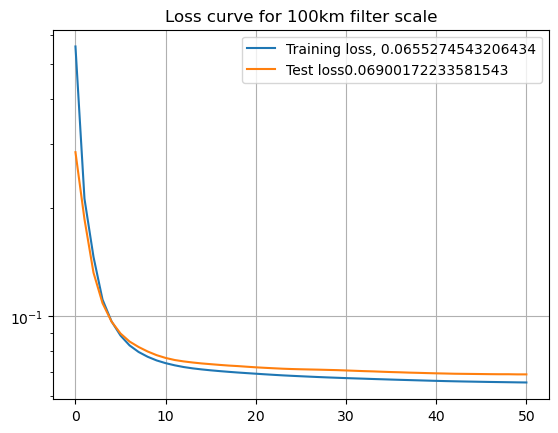

In [13]:
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve for '+ L+ 'km filter scale')
plt.grid()
plt.yscale('log')
plt.legend()

#plt.savefig('figures/'+Lsel+'km'+'/loss_curve.png')

#### Save trained model

Save the state to use in Python notebook again

In [14]:
# Save the checkpoint
CKPT_DIR = 'ckpts_'+L+'test'#+'_'+str(bias)
regress_sys.save_checkpoint(CKPT_DIR)

In [15]:
regress_sys.read_checkpoint(CKPT_DIR)

In [19]:
regress_sys.save_weights_nc('test.nc')

#### Quick check to see if model did well

In [20]:
ML_data_full = datasets.MITgcm_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
ML_data_full.convert_normed();

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Loaded from saved norm nc
Normalized data


In [23]:
# Inference step
# y_pred = model.apply(params, X_test)

ds_test_full_no_edge = ML_data_full.ML_dataset_norm

n_pred = 10

#y_pred = state.apply_fn(state.params, ds_test_full_no_edge.isel(time=slice(0,n_pred))[input_channels].to_array().transpose(...,'variable')) - y_pred_zero
y_pred = regress_sys.pred(ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.input_channels].to_array().transpose(...,'variable'))

dims = ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.output_channels].to_array().transpose(...,'variable').dims
coords = ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.output_channels].to_array().transpose(...,'variable').coords

ds_pred = xr.DataArray( y_pred, dims=dims, coords=coords).to_dataset(dim='variable')

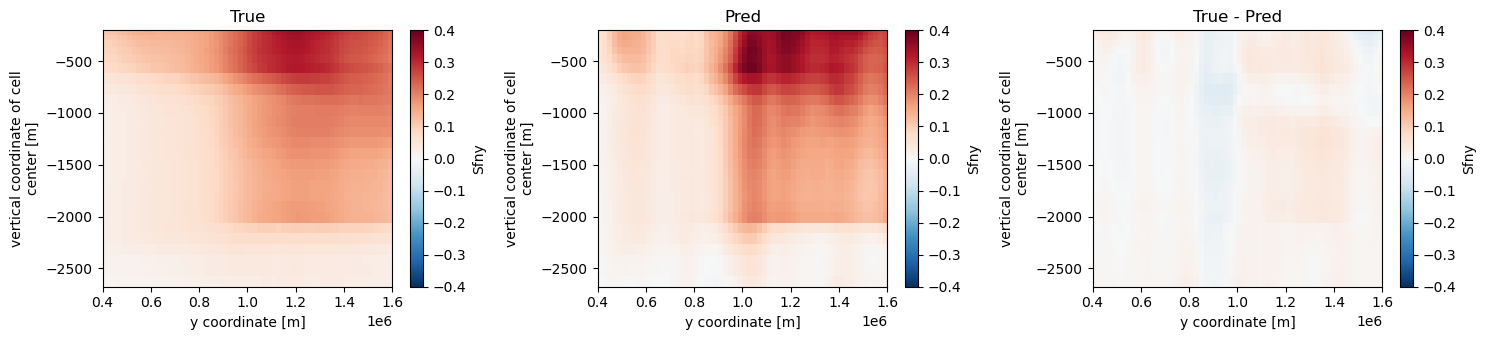

In [25]:
plt.figure(figsize=(15, 3.5))
           
plt.subplot(131)
ML_data_full.ML_dataset_norm.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True')

plt.subplot(132)
ds_pred.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('Pred')

plt.subplot(133)
(ML_data_full.ML_dataset_norm-ds_pred).Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True - Pred')


plt.tight_layout()

#plt.savefig('figures/'+Lsel+'km'+'/zonal_avg'+'_'+str(bias)+'.png')

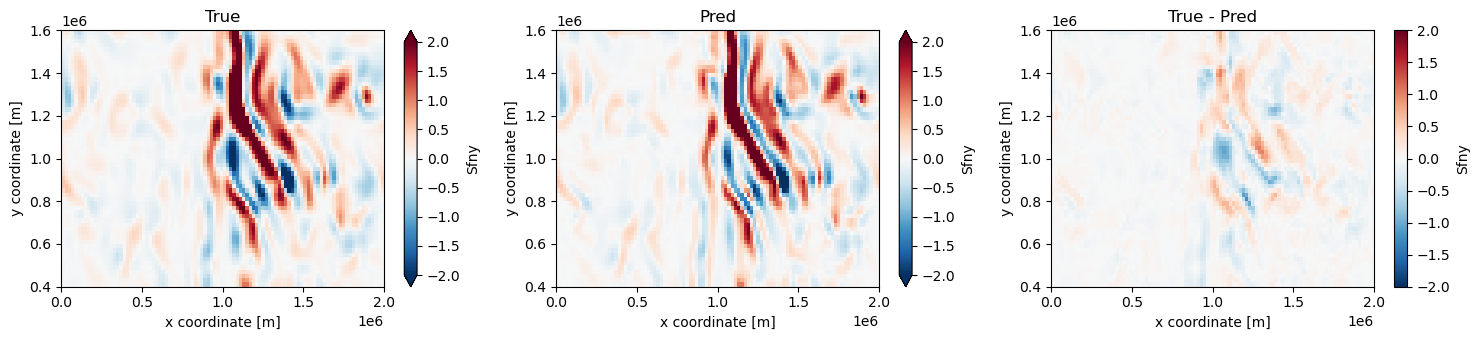

In [26]:
plt.figure(figsize=(15, 3.5))
zlev=-15
vlevs = 2.
plt.subplot(131)
ML_data_full.ML_dataset_norm.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')

plt.subplot(132)
ds_pred.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('Pred')

plt.subplot(133)
(ML_data_full.ML_dataset_norm-ds_pred).Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('True - Pred')


plt.tight_layout()
#plt.savefig('figures/'+Lsel+'km'+'/XY_section'+'_'+str(bias)+'.png')

In [40]:
R2_XY = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z'])
R2_XZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','YC'])
R2_YZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC'])

R2_uT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z','XC','YC'])
R2_vT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','Z','XC','YC'])

R2_uT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC','YC'])
R2_vT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','XC','YC'])

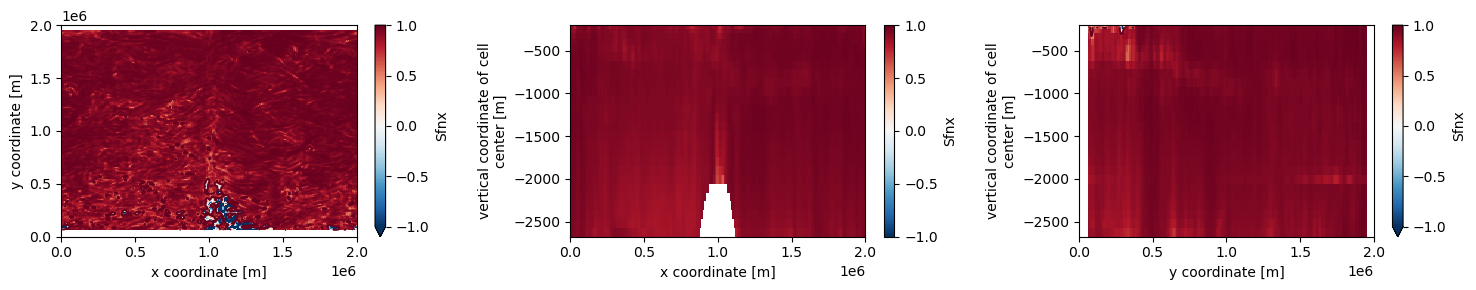

In [41]:
plt.figure(figsize=(15, 3))
           
vlim = 1.

plt.subplot(131)
R2_XY.plot(x='XC', vmin=-vlim)
R2_XY.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(132)
R2_XZ.plot(x='XC', vmin=-vlim)
R2_XZ.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(133)
R2_YZ.plot(x='YC', vmin=-vlim)
R2_YZ.plot.contour(levels=[0.5], x='YC', vmin=-vlim)

plt.tight_layout()

plt.savefig('figures/'+Lsel+'km'+'/R2_sections'+'_'+str(bias)+'.png')

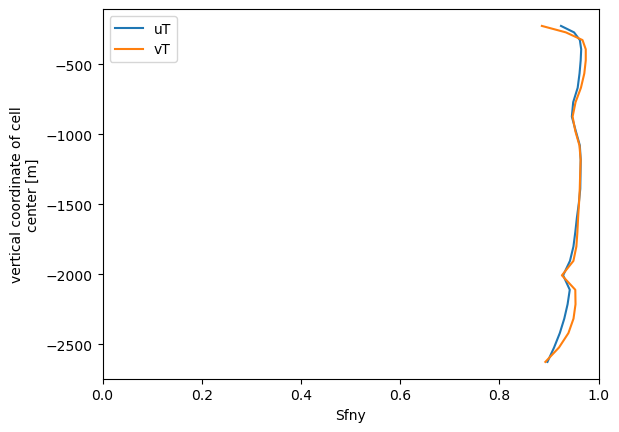

In [42]:
R2_uT_z.plot(y='Z', label='uT')
R2_vT_z.plot(y='Z', label='vT')
plt.xlim([0,1])
plt.legend()

plt.savefig('figures/'+Lsel+'km'+'/R2_profile.png')

## Fin